In [1]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
iris = datasets.load_iris()
features = iris.data
target = iris.target

sepal_length = np.array(features[:,0])
petal_width = np.array(features[:,3])

species_map = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
species_names = [species_map[i] for i in target]

In [3]:
def predict(intercept, coefficient, dataset):
    return np.array([intercept + coefficient * x for x in dataset])

def create_batches(x, y, batch_size):
    x_batches = np.array_split(x, len(x) // batch_size)
    y_batches = np.array_split(y, len(y) // batch_size)
    return x_batches, y_batches

def mbgd(x, y, epochs, df, batch_size, alpha = 0.01):
    intercept, coefficient = 2.0, -7.5
    x_batches, y_batches = create_batches(x, y, batch_size)

    predictions = predict(intercept, coefficient, x_batches[0])
    error = predictions - y_batches[0]
    mse = np.sum(error ** 2) / (2 * batch_size)
    df.loc[0] = [intercept, coefficient, mse]
    
    index = 1
    for _ in range(epochs):
        for batch_x, batch_y in zip(x_batches, y_batches):
            predictions = predict(intercept, coefficient, batch_x)
            error = predictions - batch_y
            intercept_gradient = np.sum(error) / batch_size
            coefficient_gradient = np.sum(error * batch_x) / batch_size
            intercept = intercept - alpha * intercept_gradient
            coefficient = coefficient - alpha * coefficient_gradient
            mse = np.sum(error ** 2) / (2 * batch_size)
            df.loc[index] = [intercept, coefficient, mse]
            index += 1
    return df

In [4]:
epochs = 5000
mbgd_loss = pd.DataFrame(columns=['intercept', 'coefficient', 'mse'])
mbgd_loss = mbgd(sepal_length, petal_width, epochs = epochs, batch_size=64, df = mbgd_loss)

In [5]:
mbgd_loss.tail()

,intercept,coefficient,mse
9996,-2.816723,0.700358,0.141946
9997,-2.820381,0.680671,0.121233
9998,-2.817006,0.700404,0.141946
9999,-2.820663,0.680719,0.121221
10000,-2.817289,0.700451,0.141946


In [6]:
total = len(mbgd_loss) - 1
half = int(epochs / 2)
quarter = int(epochs / 4)

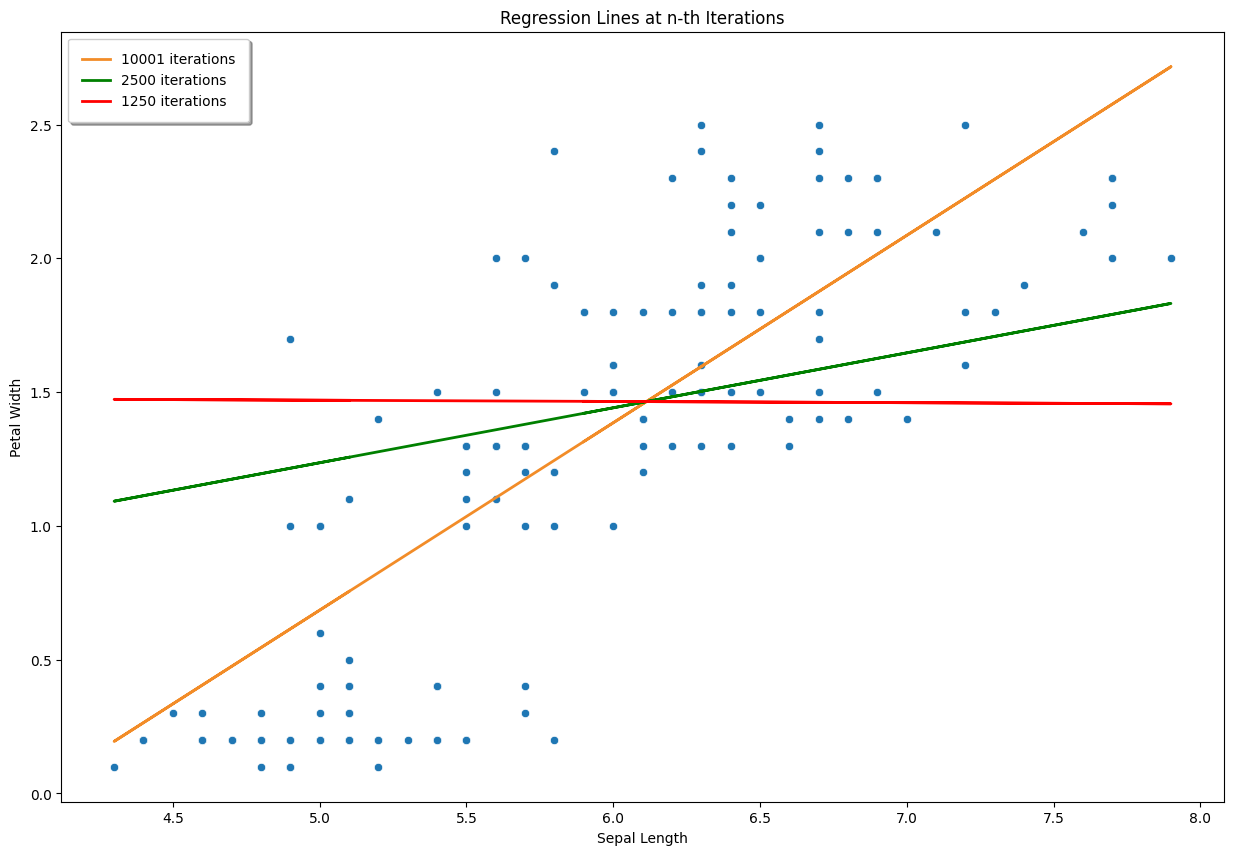

In [7]:
plt.figure(figsize=(15, 10))

sns.scatterplot(
    x = sepal_length, 
    y = petal_width
)

plt.plot(
    sepal_length, 
    mbgd_loss['intercept'][total] + mbgd_loss['coefficient'][total] * sepal_length,
    '#f28c28',
    linewidth = 2,
    label = f'{total + 1} iterations'
)

plt.plot(
    sepal_length, 
    mbgd_loss['intercept'][half] + mbgd_loss['coefficient'][half] * sepal_length,
    '-g',
    linewidth = 2,
    label = f'{half} iterations'
)

plt.plot(
    sepal_length, 
    mbgd_loss['intercept'][quarter] + mbgd_loss['coefficient'][quarter] * sepal_length,
    '-r',
    linewidth = 2,
    label = f'{quarter} iterations'
)

plt.title("Regression Lines at n-th Iterations")
plt.xlabel("Sepal Length")
plt.ylabel("Petal Width")

plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

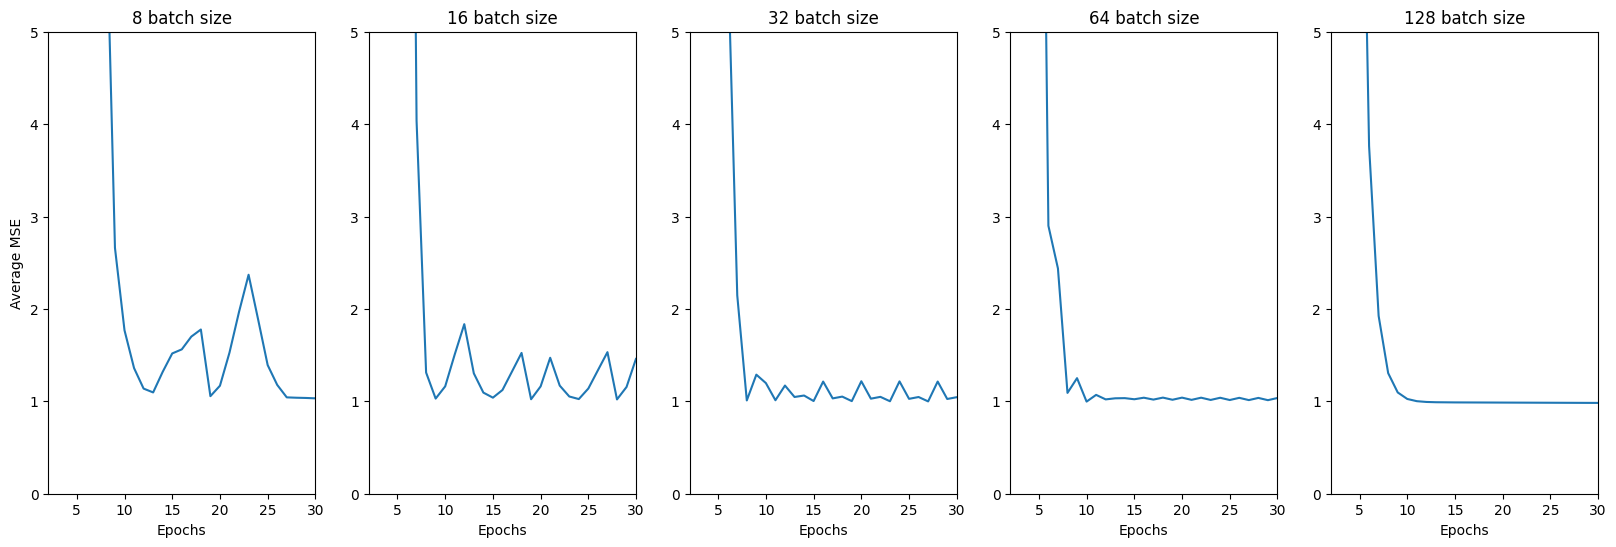

In [8]:
fig, ax = plt.subplots(1, 5, figsize=(20, 6))

batch_sizes = [8, 16, 32, 64, 128]
colors = ['green', 'red', 'blue', 'orange', 'purple']
y_true = petal_width

for i, (size, color) in enumerate(zip(batch_sizes, colors)):
    loss = pd.DataFrame(columns=['intercept', 'coefficient', 'mse'])
    loss = mbgd(sepal_length, petal_width, epochs = 500, batch_size=size, df = loss)

    y_pred = list()
    for intercept, coefficient in zip(loss['intercept'], loss['coefficient']):
        y_pred.append(intercept + coefficient * sepal_length)

    mse = [np.mean((y - y_true) ** 2) for y in y_pred]

    ax[i].plot(mse)
    ax[i].set_ylim(0, 5)
    ax[i].set_xlim(2, 30)
    ax[i].set_title(f'{size} batch size')
    if i == 0:
        ax[i].set_ylabel('Average MSE')
    ax[i].set_xlabel('Epochs')

In [9]:
intercepts = np.linspace(-5, 5, 50)
coefficients = np.linspace(-10, 10, 50)
x, y = np.meshgrid(intercepts, coefficients)
z = np.zeros(x.shape)

# calculate the mean squared error for each point on the surface
z = np.array([[mean_squared_error(
    predict(x_i, y_i, sepal_length),
    petal_width
) for x_i in intercepts] for y_i in coefficients])

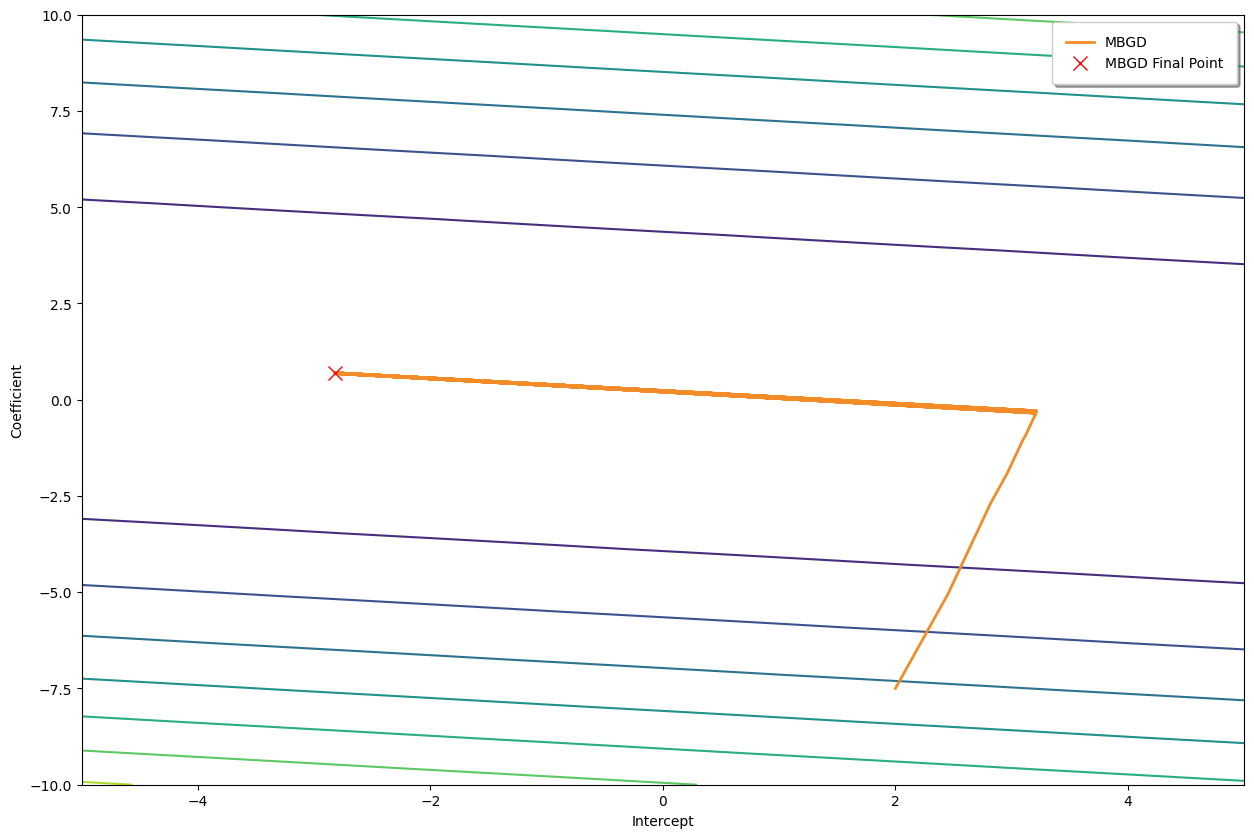

In [10]:
plt.figure(figsize=(15, 10))
plt.contour(x, y, z)
plt.plot(mbgd_loss['intercept'][0:len(mbgd_loss)-2], mbgd_loss['coefficient'][0:len(mbgd_loss)-2], color="#f28c28", linewidth=2, label="MBGD")
plt.plot(mbgd_loss['intercept'][len(mbgd_loss)-1], mbgd_loss['coefficient'][len(mbgd_loss)-1], 'x', markersize=10, color='red', label="MBGD Final Point")
plt.xlabel("Intercept")
plt.ylabel("Coefficient")
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)